In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
! git add .
!

In [ ]:
%cd /content/gdrive/MyDrive/research/SWIL-Comparisons
! pip3 install -r requirements.txt

/content/gdrive/MyDrive/research/SWIL-Comparisons


In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/research/SWIL-Comparisons/src')

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim

import matplotlib.pyplot as plt
import numpy as np

from utils.nets import *
from utils.model_tools import *
from utils.feature_extractor import *
from utils.dataset_tools import *
from utils.cosine_similarity import *

# TODO: clean these up later
from torchvision.datasets import CIFAR10, FashionMNIST
from sklearn.metrics import pairwise_distances

import random

ModuleNotFoundError: ignored

### Questions
- SWIL vs FIL or SWIL vs nothing
- principle component analysis?

### Notes

- train or get no-il model files (retrained)
- train or get swil model files (retrained)
- looking at l2 distance between centroids
- representations of classes from the last layer
- examine that data and visualize it to understand

In [ ]:
pretrained_path = "./models/linear_fashionmnist_holdout_[8, 9].pt"
swil_retrained_frozen_path = "./models/linear_fashionmnist_holdout_[8]_swil.pt" # this correct or swil?
fil_retrained_frozen_path = "./models/linear_fashionmnist_holdout_[8]fil.pt" # not sure this one is good

In [ ]:
layer_names = ['input_layer', 'output_layer']

pretrained = torch.load(pretrained_path)
swil_ckpt = torch.load(swil_retrained_frozen_path)
fil_ckpt = torch.load(fil_retrained_frozen_path)

num_outputs = swil_ckpt['output_layer.weight'].shape[0]
input_size = swil_ckpt['input_layer.weight'].shape[1]

swil_retrained = nets.LinearFashionMNIST_alt(input_size, num_outputs)
fil_retrained = nets.LinearFashionMNIST_alt(input_size, num_outputs)
swil_retrained.load_state_dict(swil_ckpt)
fil_retrained.load_state_dict(fil_ckpt)

swil_feat = FeatureExtractor(swil_retrained, layers=layer_names)
fil_feat = FeatureExtractor(fil_retrained, layers=layer_names)

In [ ]:
transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5), (0.5)),]) # Images are grayscale -> 1 channel

test_data = FashionMNIST(root='./data', train=False, download=True, transform=transform)

print(len(test_data))

included_data, excluded_data = split_training_data(test_data, [8]) # excluding 8? seems wrong?
loader = DataLoader(included_data, batch_size=1, shuffle=False, num_workers=2)
print(len(loader))

9000


In [ ]:
# TODO figure out what's going on with swap and maybe retrain models if need be
# although accuracy is looking ok right now for fil and swil, maybe swil a bit low

# need to store x and y or will loader give it in the same order later?
fil_points = {'input_layer': np.zeros((len(loader), 128)), 'output_layer': np.zeros((len(loader), 9))} # 3d matrix: layer activations per example per layer (dimension of layer output?)
swil_points = {'input_layer': np.zeros((len(loader), 128)), 'output_layer': np.zeros((len(loader), 9))}

targets = []
#fil_retrained.eval()
#swil_retrained.eval()
with torch.no_grad():
    for step, (x, y) in enumerate(loader):
        # don't forget to swap labels
        for i in range(len(y)):
            if y[i] == 9: # do I need to swap labels at all
                y[i] = 8
        targets.append(y)
        fil_actives = fil_feat(x)
        swil_actives = swil_feat(x)
        for layer in layer_names:
            fil_points[layer][step] = fil_actives[layer].numpy().flatten()
            swil_points[layer][step] = swil_actives[layer].numpy().flatten()
        

In [ ]:
targets = np.array([x.tolist()[0] for x in targets]) # I know this is a dumb way to do this

In [ ]:
# pairwise matrix of distances between samples and group by class to visualize patterns
fil_dist = {}
swil_dist = {}
sample_size = 700

target_sort = np.argsort(targets)
sorted_targets = targets[target_sort]

for layer in layer_names:
    # need to group by classes first
    fil_byclass = fil_points[layer][target_sort]
    swil_byclass = swil_points[layer][target_sort]
    # sampling per class
    fil_classes = []
    swil_classes = []
    for i in range(9):
        rand_idx = [random.randint(i*1000, (i+1)*999) for j in range(sample_size)]
        fil_classes.append(fil_byclass[rand_idx])
        swil_classes.append(swil_byclass[rand_idx])
    
    fil_dist[layer] = pairwise_distances(np.concatenate(fil_classes))
    swil_dist[layer] = pairwise_distances(np.concatenate(swil_classes))

In [ ]:
# no difference here which makes total sense

print(fil_dist['input_layer'][:5,:5])
print(swil_dist['input_layer'][:5,:5])

[[ 0.         19.67356729 25.34978822 45.25051515 30.94962534]
 [19.67356729  0.         17.26473607 34.4062073  22.88477979]
 [25.34978822 17.26473607  0.         34.08508245 26.57438119]
 [45.25051515 34.4062073  34.08508245  0.         16.88438217]
 [30.94962534 22.88477979 26.57438119 16.88438217  0.        ]]
[[ 0.         19.67356729 25.34978822 45.25051515 30.94962534]
 [19.67356729  0.         17.26473607 34.4062073  22.88477979]
 [25.34978822 17.26473607  0.         34.08508245 26.57438119]
 [45.25051515 34.4062073  34.08508245  0.         16.88438217]
 [30.94962534 22.88477979 26.57438119 16.88438217  0.        ]]


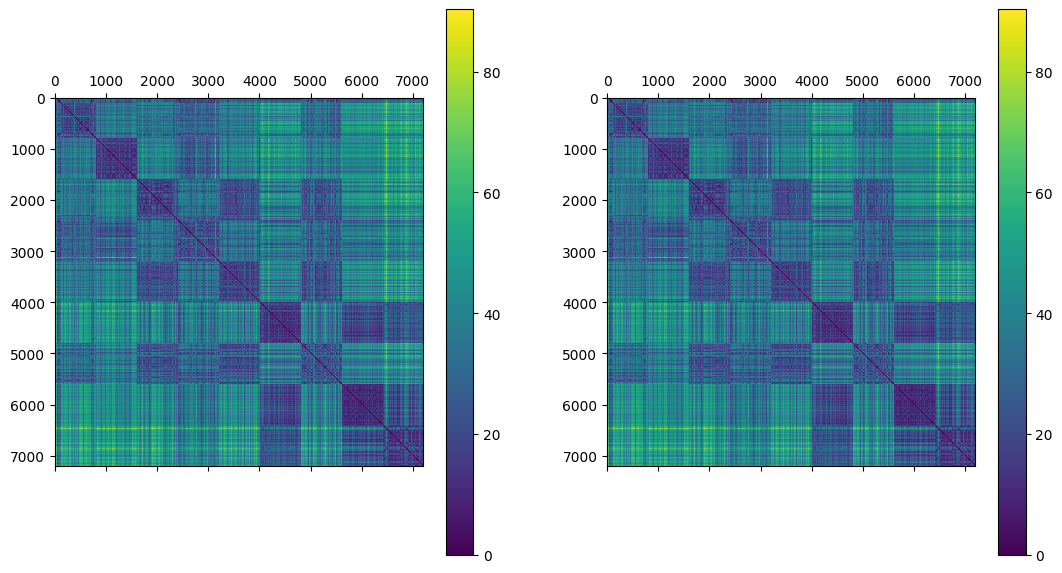

In [ ]:
#0 T-shirt/top
#1 	Trouser
#2 	Pullover
#3 	Dress
#4 	Coat
#5 	Sandal
#6 	Shirt
#7 	Sneaker
#8 	Ankle boot

# expected results here, sneaker and sandal similar, etc

fig = plt.figure()
ax = fig.add_subplot(221)

fil_mat = ax.matshow(fil_dist['input_layer'])

ax = fig.add_subplot(222)
swil_mat = ax.matshow(swil_dist['input_layer'])
plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
fig.colorbar(fil_mat)
fig.colorbar(swil_mat)

fig.set_figheight(15)
fig.set_figwidth(15)

plt.show()

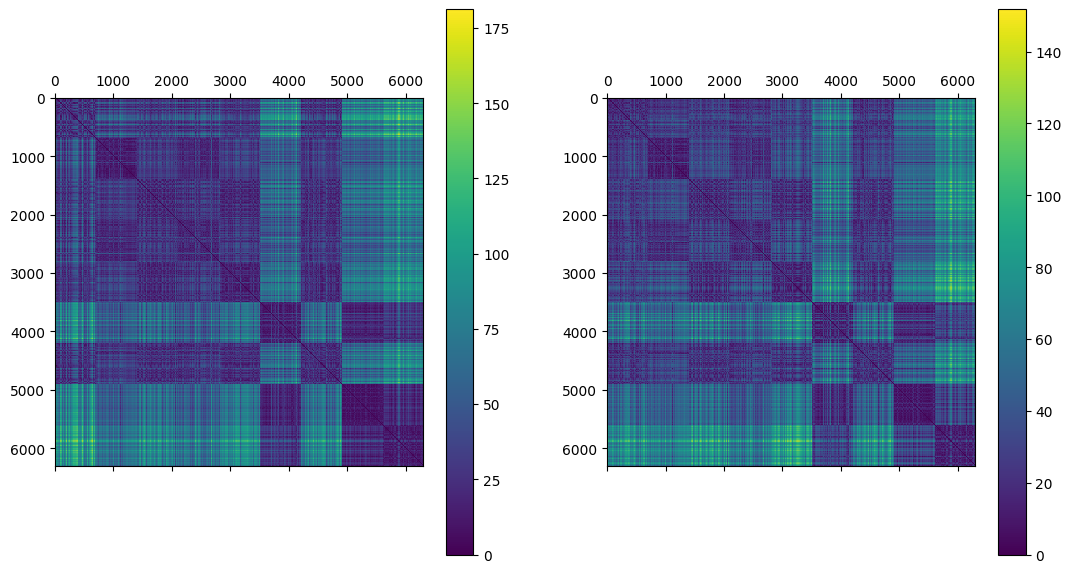

<Figure size 640x480 with 0 Axes>

In [ ]:
#0 T-shirt/top
#1 	Trouser
#2 	Pullover
#3 	Dress
#4 	Coat
#5 	Sandal
#6 	Shirt
#7 	Sneaker
#8 	Ankle boot

# expected results here, sneaker and sandal similar, etc

fig = plt.figure()
ax = fig.add_subplot(221)

fil_mat = ax.matshow(fil_dist['output_layer'])

ax = fig.add_subplot(222)
swil_mat = ax.matshow(swil_dist['output_layer'])
plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
fig.colorbar(fil_mat)
fig.colorbar(swil_mat)

fig.set_figheight(15)
fig.set_figwidth(15)

plt.show()
plt.savefig('./figs/fmnist_fil_swil_output_700.png')

# swil is about 1% less accurate than fil
# noticing that swil is overall less separated
# fil differentiates t-shirt class more than swil
# swil maybe slightly focuses more on the new class?

## CIFAR 10 CNN

(I will be making these into generic methods later)

In [ ]:
pretrained_path = "./models/linear_fashionmnist_holdout_[8, 9].pt"
swil_retrained_frozen_path = "./models/linear_fashionmnist_holdout_[8]_swil.pt" # this correct or swil?
fil_retrained_frozen_path = "./models/linear_fashionmnist_holdout_[8]fil.pt" # not sure this one is good